In [5]:
import warnings
warnings.filterwarnings('ignore')
import torch
import numpy as np
import torch.nn as nn
import cv2
from transformers import Dinov2Model, AutoImageProcessor
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
import torchvision.transforms as transforms
from PIL import Image

In [6]:
class Dinov2BinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = "facebook/dinov2-small",
        hidden_dim: int = 512,
        dropout_prob: float = 0.4,
    ):
        """
        Param:
            - backbone_name: Hugging Face Dinov2 
            - hidden_dim: hidden dim
            - dropout_prob: dropout ratio
        """
        super().__init__()
        # 1) data preprocessing (check next cell for deatils)
        self.processor = AutoImageProcessor.from_pretrained(backbone_name)

        # 2) load pretrained weight
        self.backbone = Dinov2Model.from_pretrained(backbone_name)

        # 3) Classification Head：CLS token -> hidden_dim -> ReLU -> Dropout
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # BCE 1 dim output
        )

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        """
        Param:
            - pixel_values: shape = (batch_size, 3, image_size, image_size),
        Output:
            - logits: shape = (batch_size, 2) raw score
        """
        # 1) send input into Dinov2 backbone,get last_hidden_state
        #    outputs.last_hidden_state = (batch_size, seq_len, hidden_size)，
        #    seq_len = patch + 1（CLS token）
        outputs = self.backbone(pixel_values=pixel_values)
        last_hidden = outputs.last_hidden_state  # (B, seq_len, hidden)

        # 2) get CLS token：last_hidden[:, 0, :]
        cls_token = last_hidden[:, 0, :]  # (B, hidden_size)

        # 3) sends CLS toekn
        logits = self.classifier(cls_token)  # (B, 2)
        return logits

In [7]:
dino = Dinov2BinaryClassifier(hidden_dim=256, dropout_prob=0.4)  
dino.load_state_dict(torch.load("dinov2_small_256_.4.pth"))
dino.eval()

Dinov2BinaryClassifier(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerSca

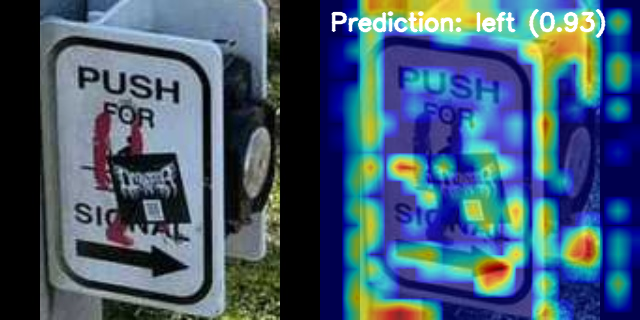

In [52]:
image_path = 'ClassificationDataset_label/low/5.jpg'
# https://polara.com/blog/what-is-an-aps
# image_path = 'ClassificationDataset_label/l.jpg'
# image_path = 'ClassificationDataset_label/train/right/782b989b-23d7d687-IMG_20250504_161413_0_class0.jpg'
img = Image.open(image_path).convert("RGB")
img_np = np.array(img).astype(np.float32) / 255.0  # (H, W, 3) RGB [0, 1]

transform = transforms.Compose([
    transforms.PILToTensor(), 
    transforms.ConvertImageDtype(torch.float32),
    # transforms.Resize(320),
    # transforms.Normalize((0.1835, 0.1857, 0.1900), (0.3012, 0.3032, 0.3080))
])
input_tensor = transform(img).unsqueeze(0)

# === 2. GradCAM reshape_transform  ===
def dino_reshape_transform(x):
    x = x[:, 1:, :]
    B, N, C = x.shape
    H = W = int(N ** 0.5)
    return x.reshape(B, H, W, C).permute(0, 3, 1, 2)

# === 3. set layer ===
targets = [ClassifierOutputTarget(0)]
target_layers = [dino.backbone.encoder.layer[-1].norm1] 

# === 4. GradCAM forward ===
with GradCAM(model=dino, target_layers=target_layers, reshape_transform=dino_reshape_transform) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cams[0]
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)
    grayscale_cam = grayscale_cam ** 0.5

    # convert img_np
    img_bgr = img_np[..., ::-1]
    cam_image = show_cam_on_image(img_bgr, grayscale_cam, use_rgb=True, image_weight=0.4)

# === 5. show prediction ===
logit = dino(input_tensor)
score = torch.sigmoid(logit).item()
label = "left" if score < 0.5 else "right"
display_score = 1.0 - score if label == "left" else score
text = f"Prediction: {label} ({display_score:.2f})"

cam_with_text = cam_image.copy()
cv2.putText(cam_with_text, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
            0.8, (255, 255, 255), 2, cv2.LINE_AA)

# === 6. stack results ===
img_uint8 = np.uint8(255 * img_np)  
images = np.hstack((img_uint8, cam_with_text))  

# === 7. show image ===
Image.fromarray(images)

Probability before : 0.0704
Probability after  : 0.4280
Confidence increase: 35.76%


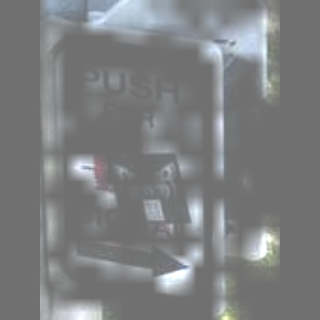

In [57]:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange

def print_confidence_change(model, input_tensor, logit_delta, target_index=0):
    model.eval()
    with torch.no_grad():
        original_logits = model(input_tensor)
        if original_logits.dim() == 2 and original_logits.size(1) > 1:
            logit_before = original_logits[0, target_index].item()
        else:
            logit_before = original_logits[0].item()
    logit_after = logit_before + logit_delta
    prob_before = torch.sigmoid(torch.tensor(logit_before)).item()
    prob_after = torch.sigmoid(torch.tensor(logit_after)).item()
    
    # print(f"ogit delta         : {logit_delta:.4f}")
    print(f"Probability before : {prob_before:.4f}")
    print(f"Probability after  : {prob_after:.4f}")
    print(f"Confidence increase: {100 * (prob_after - prob_before):.2f}%")

targets = [ClassifierOutputTarget(0)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, dino, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)

print_confidence_change(dino, input_tensor, logit_delta=score, target_index = 1)
Image.fromarray(visualization)
